<a href="https://colab.research.google.com/github/josedanielisidororeyes/Anal-tica-Descriptiva-y-Predictiva/blob/main/Capstone_Proyect_12526.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project MsFE
## Proyect: Deep Reinformcent Learning for Cryptocurrency Trading
## Student Group: 12526
## Team Members:


*   Jose Daniel Isidoro Reyes
*   Jayakumar G



This notebook presents the design and initial experimentation of a PPO-LSTM trading agent
implemented using the FinRL framework on 1-minute ETH/USDT data. The focus of Module 4
has been done on the system design, methodological justification, and feasibility validation.


## Setup

In [ ]:
# Instalation
%%capture
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make
!make install

%cd /content/
!pip install TA-Lib

!pip install ccxt


In [ ]:
%%capture
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install sb3-contrib

In [ ]:
# Loading Libraries
import ccxt
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import talib
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")
#pd.set_option('display.float_format', lambda x: '%.2f' % x)

# RL libraries
from sklearn.preprocessing  import StandardScaler
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from sb3_contrib import RecurrentPPO
import gymnasium as gym
import pyfolio as pf

# 1) Data Adquisition

In [ ]:
# @title
#
exchange = ccxt.coinbase({'enableRateLimit': True})

symbol =  'ETH/USD'
timeframe =  '1m'
limit  =  800

# Data Retrieval Configuration
START_DATE =  '2020-01-01 00:00:00'
END_DATE = '2025-08-30 00:00:00'

start_dt = datetime.strptime(START_DATE, '%Y-%m-%d %H:%M:%S')
end_dt   = datetime.strptime(END_DATE, '%Y-%m-%d %H:%M:%S')

since = exchange.parse8601(start_dt.strftime('%Y-%m-%dT%H:%M:%SZ'))
end_ts = exchange.parse8601(end_dt.strftime('%Y-%m-%dT%H:%M:%SZ'))


data =  []

while since < end_ts:
    ohlcv =  exchange.fetch_ohlcv(
        symbol,
        timeframe  =  timeframe,
        since  =  since,
        limit  =  limit)

    for candle in ohlcv:
        if candle[0] <= end_ts:
            data.append(candle)

    since  =  ohlcv[-1][0] + 1
    time.sleep(0.35)
df = pd.DataFrame(data,
                  columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'] )
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# 2) Exploratory Data Analysis


In [ ]:
# Retrieving 3 years of data
df =  pd.read_csv('/content/drive/MyDrive/Deep Learning Fundamentals/eth_min_df.csv')
df =  df.iloc[:, 0:6]
df.rename(columns = {'timestamp': 'date'}, inplace  =  True)
df['date'] =  pd.to_datetime(df['date'])
df.set_index('date', inplace  = True)
df['tic'] = "ETH"
df.head(1)

,open,high,low,close,volume,tic
date,,,,,,
2020-01-01 01:28:00,129.6,129.64,129.55,129.59,52.761415,ETH


## Exploratory Data Analysis

In [ ]:
# Dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2627671 entries, 2020-01-01 01:28:00 to 2025-01-01 00:00:00
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
 5   tic     object 
dtypes: float64(5), object(1)
memory usage: 140.3+ MB


In [ ]:
# Descritive Statistics
df.describe()

,open,high,low,close,volume
count,2.627671e+06,2.627671e+06,2.627671e+06,2.627671e+06,2.627671e+06
mean,1.982404e+03,1.983640e+03,1.981144e+03,1.982409e+03,1.353366e+02
std,1.147113e+03,1.147839e+03,1.146370e+03,1.147115e+03,2.601256e+02
min,9.035000e+01,9.171000e+01,9.000000e+01,9.058000e+01,6.230000e-06
25%,1.252320e+03,1.253010e+03,1.251610e+03,1.252330e+03,2.375362e+01
50%,1.870270e+03,1.870910e+03,1.869640e+03,1.870280e+03,6.084118e+01
75%,2.897940e+03,2.900005e+03,2.895690e+03,2.897965e+03,1.462888e+02
max,4.864970e+03,4.867810e+03,4.863000e+03,4.864970e+03,2.206072e+04


In [ ]:
# Missing Values
df.isnull().sum()

,0
open,0
high,0
low,0
close,0
volume,0
tic,0


In [ ]:
# Duplicated values
df.duplicated().sum()

np.int64(8)

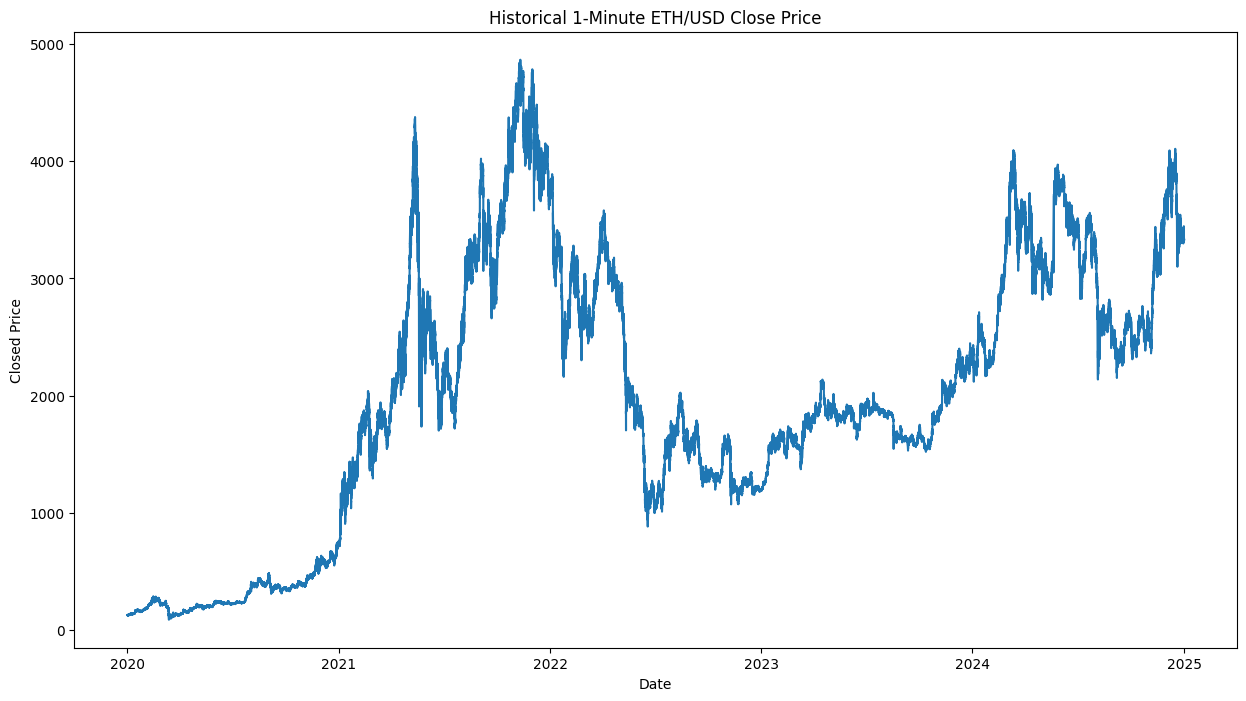

In [ ]:
# Historical ETH/USD Close Price
plt.figure(figsize=(15, 8))
plt.plot(df['close'])
plt.title('Historical 1-Minute ETH/USD Close Price')
plt.ylabel('Closed Price')
plt.xlabel('Date')
plt.show()


Text(0.5, 1.0, '1-Minute ETH/USD Return')

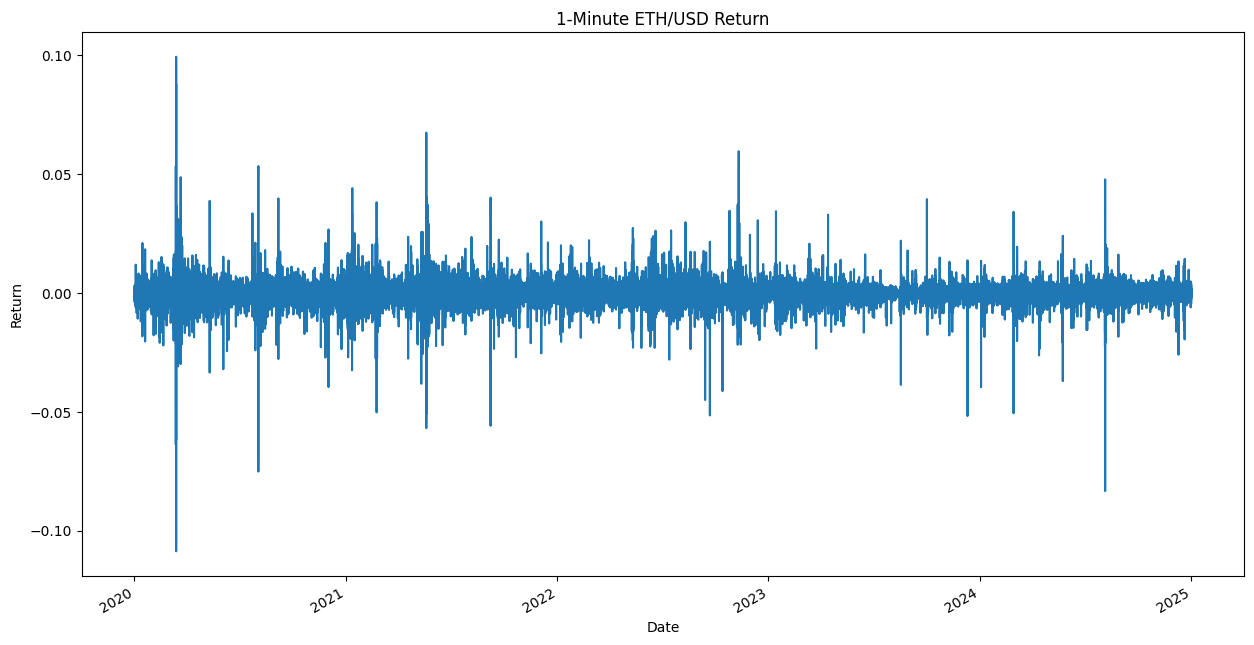

In [ ]:
plt.figure(figsize =  (15, 8))
df["close"].pct_change().plot()
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('1-Minute ETH/USD Return')


# 3) Data Preprocessing

## Data Resampling

In [ ]:
def resample_data(df, timeframe):
    return df.resample(timeframe).agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    })

df_5m =  resample_data(df, "5T")
df_15m =  resample_data(df, "5T")
df_30m =  resample_data(df, "30T")
df_60m =  resample_data(df, "60T")


## Feature Engineering

In [ ]:
def add_indicators(df):
    # Adding Technical Indicators

    # Asgary and Khasteh
    #----Commodity Channel Index----
    df['cci_14'] =  talib.CCI(df['high'], df['low'], df['close'], timeperiod  = 14)
    #df['cci_30'] =  talib.CCI(df['high'], df['low'], df['close'], timeperiod  =  30)
    #---Relative Strengh Index----
    df['rsi_14'] =  talib.RSI(df['close'], timeperiod  =  14)
    #df['rsi_30'] =  talib.RSI(df['close'], timeperiod  =  30)
    #----Moving Average Convergence Divergence ----
    df['macd'], _, _ =  talib.MACD(df['close'],
                                                                fastperiod  =  12,
                                                                slowperiod  =  26,
                                                                signalperiod  =  9)

    #----Directional Moving
    df['dx'] = talib.DX(df['high'], df['low'], df['close'], timeperiod=14)
    #----Bollinger Bands
    #df['upper_band'], df['mid_band'], df['lower_band'] = talib.BBANDS(df['close'], timeperiod=20, nbdevup=2, nbdevdn=2)
    #Chun, J. H., & Lee, S. J. (2025)
    df['roc'] = talib.ROC(df['close'])
    df['ultosc'] = talib.ULTOSC(df['high'], df['low'], df['close'])
    df['willr'] = talib.WILLR(df['high'], df['low'], df['close'])
    df['obv'] = talib.OBV(df['close'], df['volume']).astype(float)
    df['ht_dcphase'] = talib.HT_DCPHASE(df['close'])
    df['EOM'] = ((df['high'] + df['low'])/2 - (df['high'].shift(1) + df['low'].shift(1))/2) / (df['volume'] / (df['high'] - df['low']))
    df['CO'] = talib.ADOSC(df['high'], df['low'], df['close'], df['volume'])
    df['TRIX'] = talib.TRIX(df['close'])
    df['FastK'], df['FastD'] = talib.STOCHF(df['high'], df['low'], df['close'])

    #del df['open'], df['high'], df['low']

    df.dropna(inplace  =  True)
    return df

df = add_indicators(df)
df_5m =  add_indicators(df_5m)
df_15m =  add_indicators(df_15m)
df_60m =  add_indicators(df_60m)

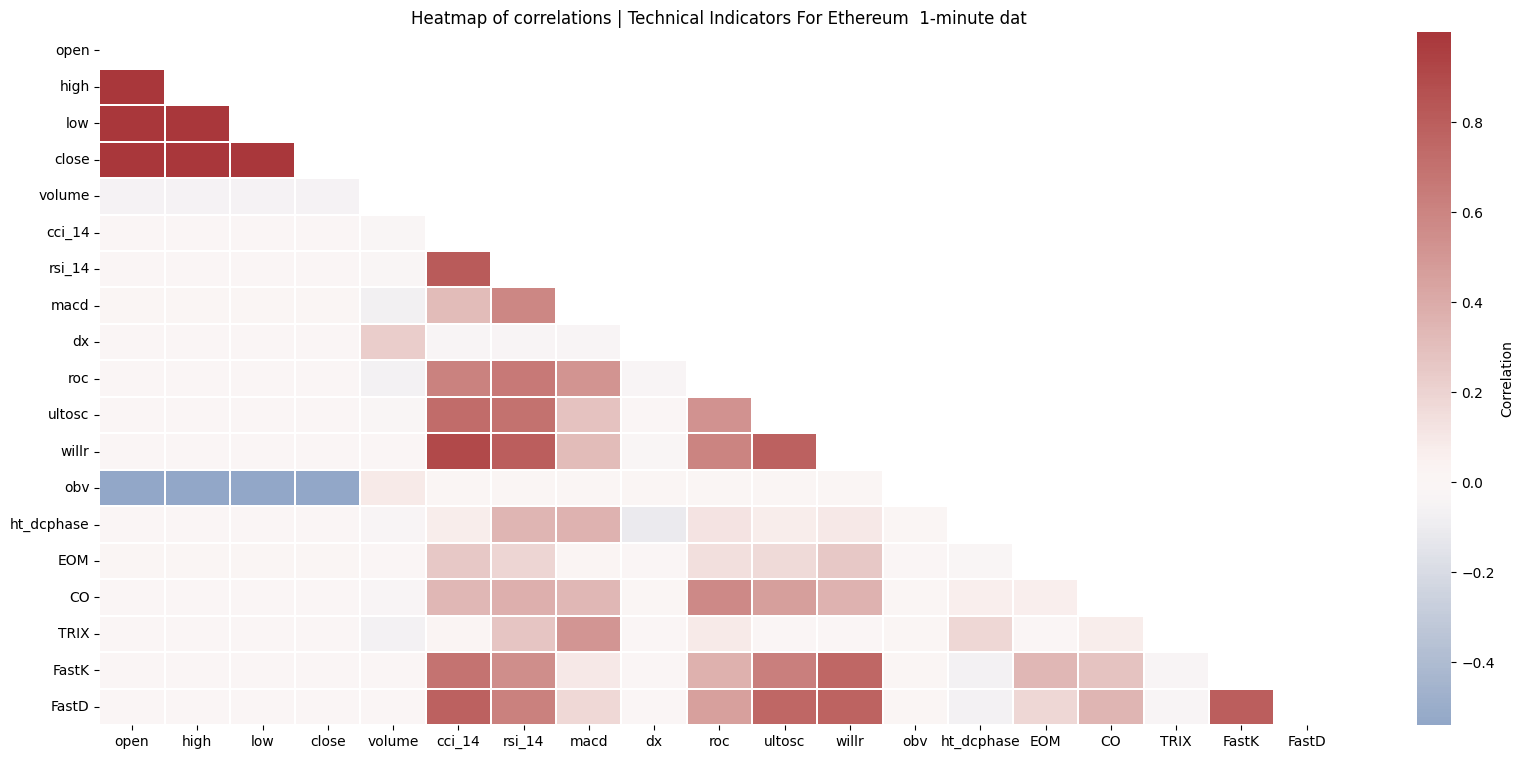

In [ ]:
corr =  df.select_dtypes(include  =  "number").corr()
mask =  np.triu(np.ones_like(corr, dtype  =  bool))
plt.figure(figsize =  (20, 9))
sns.heatmap(
    corr,
    mask  =  mask,
    cmap  = "vlag",
    annot =  False,
    linewidth  =  0.3,
    center = 0,
    cbar_kws  = {'label': 'Correlation'}

    )
plt.title("Heatmap of correlations | Technical Indicators For Ethereum  1-minute dat")
plt.show()

## **4 ) Hyperparameter Startegy**

Due to the high computational cost of PPO-LSTM training on minute-level data, a constrained
initial hyperparameter configuration is used in Module 4 to validate feasibility. A systematic
grid search and sensitivity analysis will be conducted in subsequent modules to improve
generalization and reduce overfitting.


# 5) Modelling

## Data Split

In [ ]:
df =  df.reset_index()
split  = int(len(df)*0.7)
train_df = df.iloc[:split].reset_index(drop  = True)
test_df =  df.iloc[split:].reset_index(drop  = True)

print("train_df.shape:", train_df.shape)
print("test_df.shape:", test_df.shape)

train_df.shape: (1839308, 21)
test_df.shape: (788275, 21)


## Environment

In [ ]:
indicators = [
    'cci_14', 'rsi_14',
       'macd', 'dx', 'roc', 'ultosc', 'willr', 'obv', 'ht_dcphase', 'EOM',
       'CO', 'TRIX', 'FastK', 'FastD'
]

stock_dimension  =  1
state_space  = 1 + 2*stock_dimension + stock_dimension * len(indicators)
env_kwargs =  {
    "hmax": 4,
    "initial_amount": 10000,
    "buy_cost_pct": [0.00095], # Binance
    "sell_cost_pct": [0.00095], # Binance
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": indicators,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "num_stock_shares": [0] * stock_dimension,


}


e_train_gym  =  StockTradingEnv(df =  train_df, **env_kwargs)
e_test_gym  =  StockTradingEnv(df =  test_df, **env_kwargs)

env_train =  DummyVecEnv([lambda : e_train_gym])
env_test =  DummyVecEnv([lambda: e_test_gym])

# Recurrent PPO Agent

In [ ]:
policy_kwargs =  dict(
    n_lstm_layers =  2,
    net_arch =  dict(pi =  [256, 128], vf =  [256, 128])
)


model  =  RecurrentPPO(
    "MlpLstmPolicy",
    env_train,
    policy_kwargs= policy_kwargs,
    learning_rate = 0.005,
    batch_size  =  2048,
    n_steps  =  1024,
    gamma = 0.99,
    ent_coef = 0.005,
    clip_range = 0.2,
    verbose =  1,

)


model.learn(total_timesteps  = 20000, progress_bar=True)
model.save("ppo_lstm_crypto")

Using cuda device


Output()

-----------------------------
| time/              |      |
|    fps             | 5    |
|    iterations      | 1    |
|    time_elapsed    | 173  |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 2           |
|    time_elapsed         | 379         |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.020932453 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.441       |
|    learning_rate        | 0.005       |
|    loss                 | 0.0588      |
|    n_updates            | 10          |
|    policy_gradient_loss | 0.00102     |
|    std                  | 0.976       |
|    value_loss           | 5.68        |
----------------------------------

# 6) Validation

## 7) Training Constraints

Training PPO-LSTM agents on high-frequency financial data is computationally expensive.
Therefore, the current training is performed on a limited subset of the data to validate
the learning pipeline. Extended training and robustness testing are deferred to later modules.


## 8) Initial Observations

The PPO-LSTM agent successfully interacts with the trading environment and demonstrates
stable learning behavior during training. These results confirm the feasibility of the proposed
architecture. Final performance evaluation using risk-adjusted metrics will be conducted
using out-of-sample testing in later stages of the project.

##9) Reproducibility Notes

- Framework: FinRL
- Environment: Google Colab
- Data Frequency: 1-minute ETH/USDT
- Python Version: 3.x
- Dependencies will be consolidated into a requirements.txt file
- Codebase will be migrated to a GitHub repository in later modules


- Random seeds and environment configurations will be standardized in later modules